# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

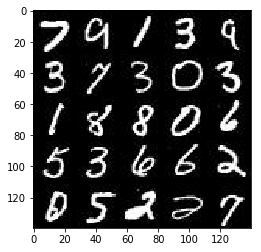

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

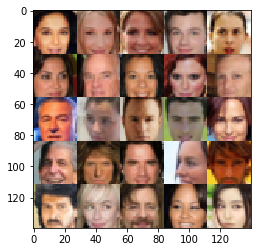

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*512)

        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.5)
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.5)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.5)

        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),"Discriminator Loss: {:.4f}...".format(train_loss_d),"Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1054... Generator Loss: 10.6671
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 8.9077
Epoch 1/2... Discriminator Loss: 0.6653... Generator Loss: 8.8899
Epoch 1/2... Discriminator Loss: 0.4391... Generator Loss: 3.8705
Epoch 1/2... Discriminator Loss: 1.7419... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 2.4138
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 2.0337
Epoch 1/2... Discriminator Loss: 1.7681... Generator Loss: 0.4181
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 1.4025
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 2.4510


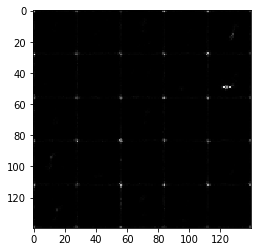

Epoch 1/2... Discriminator Loss: 2.1751... Generator Loss: 0.3562
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 1.6847... Generator Loss: 4.4202
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 3.2494
Epoch 1/2... Discriminator Loss: 1.6240... Generator Loss: 2.8968
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.3703
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 2.4029
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 1.4225


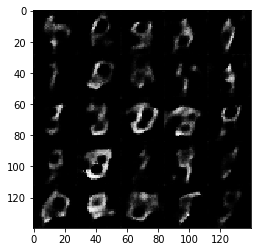

Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 1.6947... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 0.8918
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 2.3510
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.6410
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 0.8621... Generator Loss: 1.4132
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 2.2123


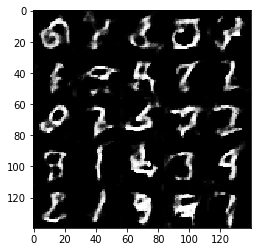

Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 1.3970
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 2.5424
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 1.9033
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.2458
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.9805
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 1.1439
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 0.8616... Generator Loss: 1.0401


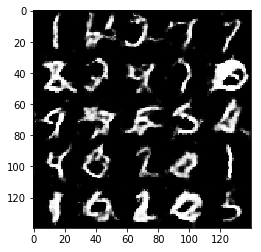

Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 0.8856
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.3641
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 1.9633
Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 1.5224
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 2.4674
Epoch 1/2... Discriminator Loss: 0.7264... Generator Loss: 1.6469
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 1.5983
Epoch 1/2... Discriminator Loss: 0.7187... Generator Loss: 1.3714
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 2.1076


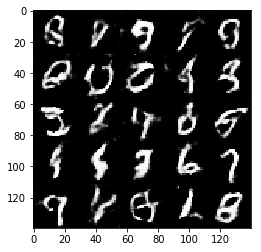

Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 2.0685
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.4427
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 1.3534
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 4.4311
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 2.2432
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 3.8071
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.8476


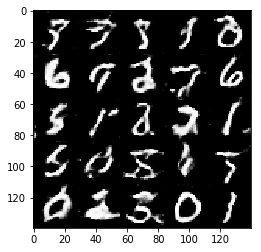

Epoch 1/2... Discriminator Loss: 0.7131... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 2.3645
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.3952
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 2.5529
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.5615
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 2.1478
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 2.0489
Epoch 1/2... Discriminator Loss: 0.5784... Generator Loss: 1.8328


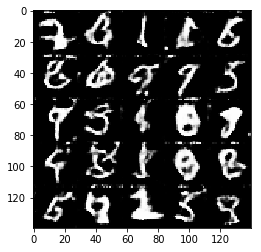

Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 3.4777
Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.6878
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.7906
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.4255
Epoch 1/2... Discriminator Loss: 0.5165... Generator Loss: 2.9108
Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 4.1156
Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 1.2124
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 2.7691
Epoch 1/2... Discriminator Loss: 0.4661... Generator Loss: 2.4946
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 1.3795


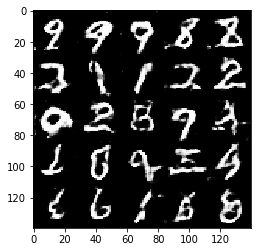

Epoch 1/2... Discriminator Loss: 0.4097... Generator Loss: 3.3885
Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 3.2911
Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 2.7752
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 3.0539
Epoch 1/2... Discriminator Loss: 0.5519... Generator Loss: 2.9716
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 1.2494
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 3.6924
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 1.7412


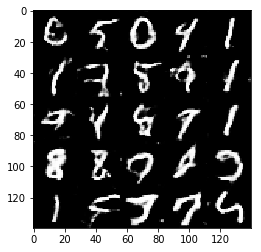

Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 1.8521
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 2.4762
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 0.5387... Generator Loss: 2.0391
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 3.2987
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 2.8185
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 2.5383
Epoch 2/2... Discriminator Loss: 0.4432... Generator Loss: 2.2200
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 2.8888


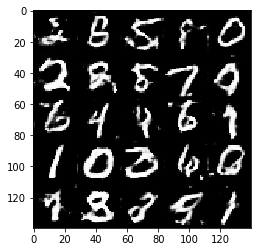

Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 3.4618
Epoch 2/2... Discriminator Loss: 0.4701... Generator Loss: 2.4392
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.7470
Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 2.4700
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 3.8159
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 0.5093... Generator Loss: 2.3872
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.6559
Epoch 2/2... Discriminator Loss: 0.4452... Generator Loss: 3.3309


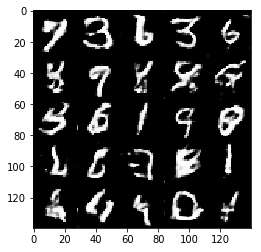

Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 3.8360
Epoch 2/2... Discriminator Loss: 0.7296... Generator Loss: 1.4106
Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 2.4868
Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.4795... Generator Loss: 3.3499
Epoch 2/2... Discriminator Loss: 0.3921... Generator Loss: 3.7955
Epoch 2/2... Discriminator Loss: 0.5424... Generator Loss: 2.1206
Epoch 2/2... Discriminator Loss: 0.5729... Generator Loss: 2.5597
Epoch 2/2... Discriminator Loss: 0.4500... Generator Loss: 2.6481
Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 2.5505


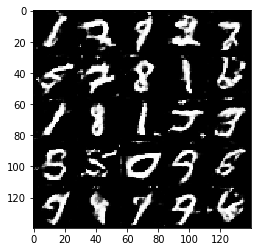

Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 4.4577
Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 3.1314
Epoch 2/2... Discriminator Loss: 0.4470... Generator Loss: 2.1725
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 3.3967
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 3.6424
Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 3.5835
Epoch 2/2... Discriminator Loss: 0.3543... Generator Loss: 3.5178
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 5.1925
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.4208


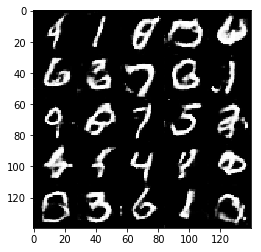

Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 2.9246
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 5.0042
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 2.8191
Epoch 2/2... Discriminator Loss: 0.5841... Generator Loss: 3.4863
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 2.4726
Epoch 2/2... Discriminator Loss: 0.4568... Generator Loss: 2.1643
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 3.6557
Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 4.4878
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 4.4505


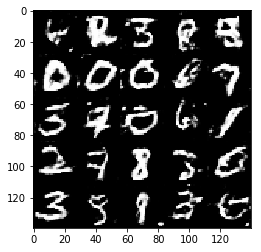

Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 3.3949
Epoch 2/2... Discriminator Loss: 0.4505... Generator Loss: 3.3060
Epoch 2/2... Discriminator Loss: 1.6020... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 2.9329
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 1.5048
Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 3.5427
Epoch 2/2... Discriminator Loss: 0.3612... Generator Loss: 4.2259
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 2.8517
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 2.5586


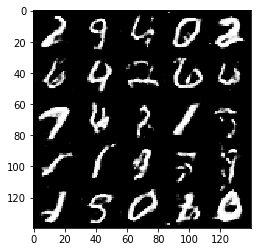

Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 2.0696
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 2.6555
Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 2.3323
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 4.0558
Epoch 2/2... Discriminator Loss: 0.3808... Generator Loss: 2.7640
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 2.3624
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 4.0855
Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 2.6693
Epoch 2/2... Discriminator Loss: 0.4325... Generator Loss: 4.0458
Epoch 2/2... Discriminator Loss: 0.4050... Generator Loss: 2.6167


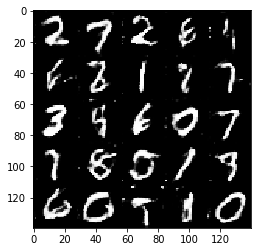

Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.4324
Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 3.5625
Epoch 2/2... Discriminator Loss: 0.3591... Generator Loss: 4.0936
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 2.7900
Epoch 2/2... Discriminator Loss: 0.3859... Generator Loss: 3.6076
Epoch 2/2... Discriminator Loss: 0.4131... Generator Loss: 3.8978
Epoch 2/2... Discriminator Loss: 0.3701... Generator Loss: 3.7954
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 3.2421
Epoch 2/2... Discriminator Loss: 0.5373... Generator Loss: 1.7282
Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 4.1302


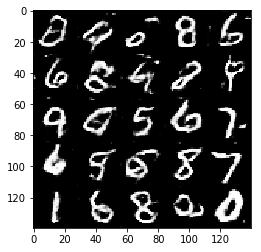

Epoch 2/2... Discriminator Loss: 0.3734... Generator Loss: 5.1649
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 4.2031
Epoch 2/2... Discriminator Loss: 0.4166... Generator Loss: 3.1049
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 1.8209
Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 2.7215
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 2.0259
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 2.4667
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 3.8832
Epoch 2/2... Discriminator Loss: 0.7223... Generator Loss: 2.0032
Epoch 2/2... Discriminator Loss: 0.4519... Generator Loss: 3.5210


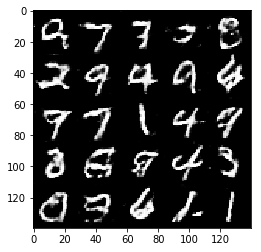

Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 2.7697
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 1.6675
Epoch 2/2... Discriminator Loss: 0.3563... Generator Loss: 4.1386
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 2.5144
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 3.5941
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.2290
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.9005


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8077... Generator Loss: 35.4454
Epoch 1/1... Discriminator Loss: 2.9083... Generator Loss: 31.0593
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 5.1908
Epoch 1/1... Discriminator Loss: 2.0166... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.4046
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.4706
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 2.2155
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 3.4287
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 4.1308
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 8.1621


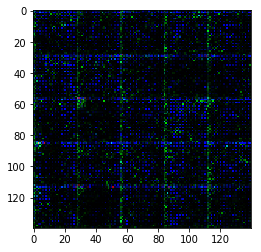

Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 6.7629
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.3438
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 3.3212
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.7572
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.8238
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.2543
Epoch 1/1... Discriminator Loss: 2.6494... Generator Loss: 6.0159
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2882


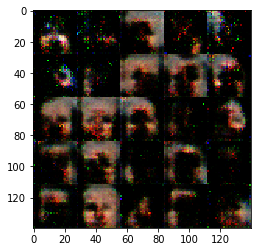

Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 2.1903
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 3.4363
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 3.0651... Generator Loss: 3.7012
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.5095
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 1.6780


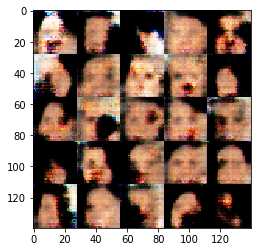

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.9382
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 2.1185
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.7241... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.8024


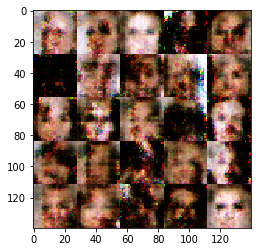

Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.4559
Epoch 1/1... Discriminator Loss: 2.1832... Generator Loss: 3.1557
Epoch 1/1... Discriminator Loss: 2.6224... Generator Loss: 2.8512
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 1.7337
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 4.1343... Generator Loss: 0.0768
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.8616


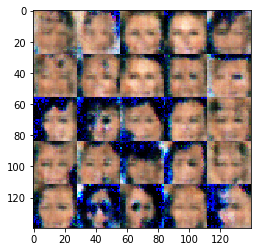

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8888


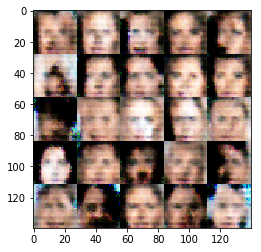

Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.0068


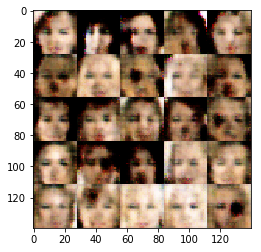

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 2.1340
Epoch 1/1... Discriminator Loss: 2.2490... Generator Loss: 2.6949
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.9914... Generator Loss: 0.2452


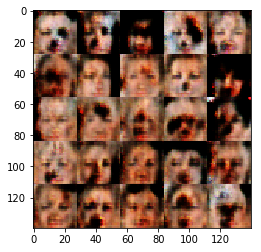

Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.6604
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.5278


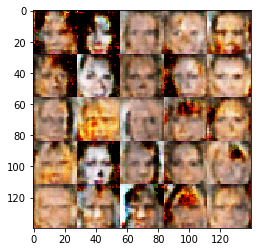

Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.0313


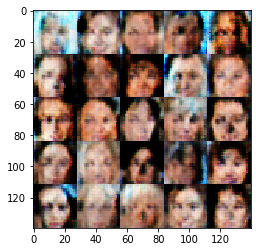

Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 1.8108


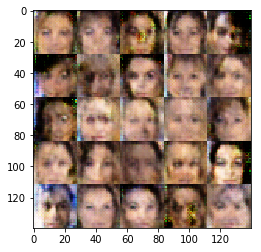

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.7383
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 0.8651


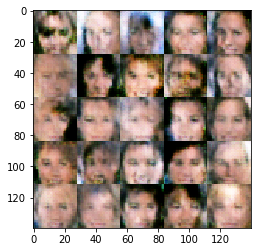

Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 2.3155
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.5933


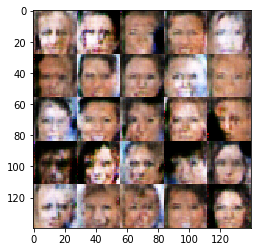

Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.5262


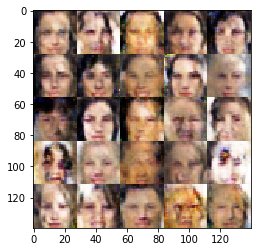

Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.7548
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.0215


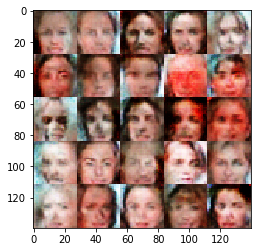

Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.7632


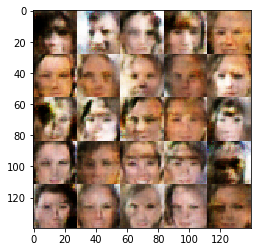

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.8089


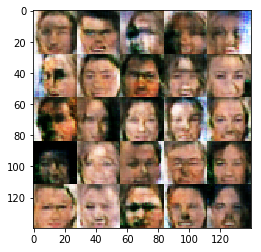

Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8748


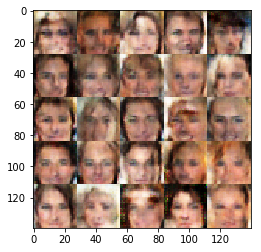

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.9628


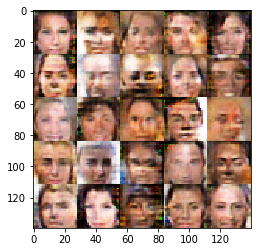

Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.1494


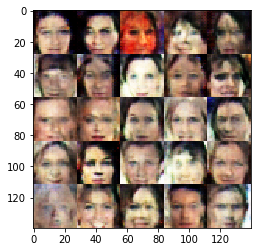

Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.6255
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.7888
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7788


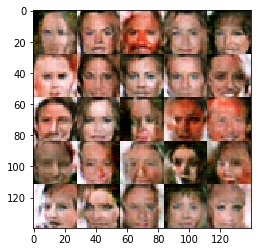

Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.7395
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6973


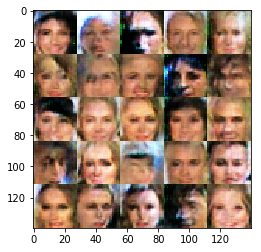

Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.2115
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9463


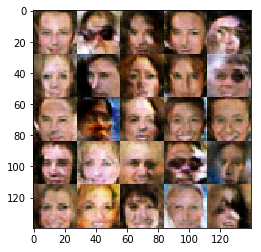

Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.9249
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.3703
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.8634
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 2.3506


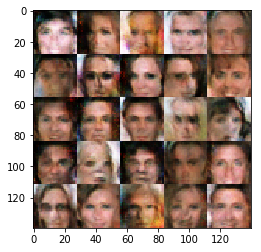

Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.1071


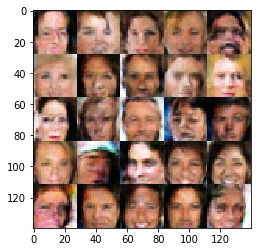

Epoch 1/1... Discriminator Loss: 1.8826... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.6044
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.9799
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 2.0754


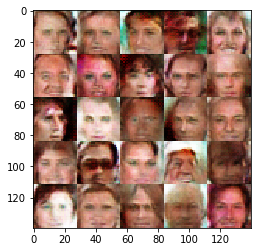

Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 2.0768


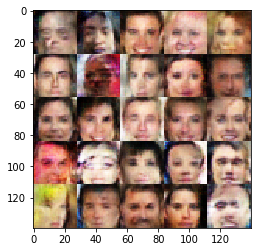

Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.6451
Epoch 1/1... Discriminator Loss: 1.7747... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 2.3145
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.2007


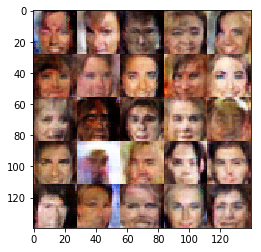

Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 2.1658


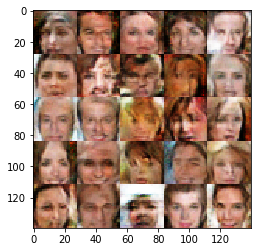

Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.4867
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 2.0455
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.3320
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.7883


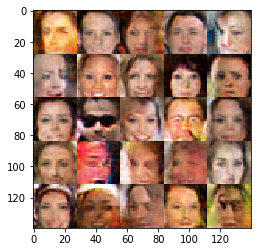

Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.5647
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.4717
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.7873


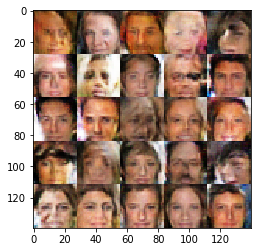

Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.9244
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.1407


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.